In [1]:
#!pip install wordcloud
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
#!pip install neattext
#!pip install plotly
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
#!pip install keras
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
#!pip install tensorflow
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("sentiment_tweets1.csv")

# preview the data
df.head()

,Index,message,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message                    10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [4]:
df.describe()

,Index,label (depression result)
count,10314.000000,10314.000000
mean,491253.470525,0.224355
std,261688.134407,0.417177
min,106.000000,0.000000
25%,263019.250000,0.000000
50%,514988.000000,0.000000
75%,773521.500000,0.000000
max,802313.000000,1.000000


In [5]:
df.shape

(10314, 3)

In [6]:
df.message

0        just had a real good moment. i missssssssss hi...
1               is reading manga  http://plurk.com/p/mzp1e
2        @comeagainjen http://twitpic.com/2y2lx - http:...
3        @lapcat Need to send 'em to my accountant tomo...
4            ADD ME ON MYSPACE!!!  myspace.com/LookThunder
                               ...                        
10309    No Depression by G Herbo is my mood from now o...
10310    What do you do when depression succumbs the br...
10311    Ketamine Nasal Spray Shows Promise Against Dep...
10312    dont mistake a bad day with depression! everyo...
10313                                                    0
Name: message, Length: 10314, dtype: object

In [7]:
df['label (depression result)'].value_counts()

0    8000
1    2314
Name: label (depression result), dtype: int64

In [17]:



df['label (depression result)'].value_counts().index.values



array([0, 1])

In [8]:
#data set split

train_data,test_data=train_test_split(df, test_size=0.2, random_state=10)



In [19]:
train_data['label (depression result)'].value_counts().index.values

array([0, 1])

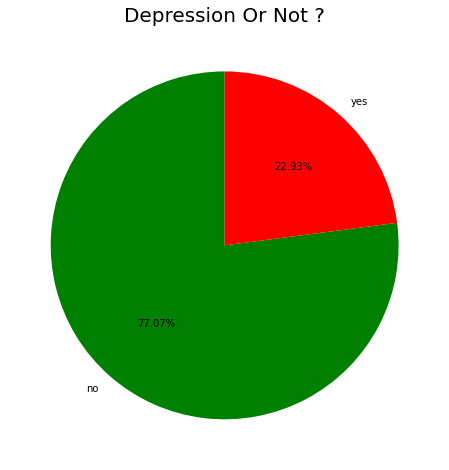

In [9]:


plt.figure(figsize=(10,8))
plt.pie(train_data['label (depression result)'].value_counts(),startangle=90,colors=['green', 'red'],
        autopct='%0.2f%%',labels=['no','yes'])
plt.title('Depression Or Not ?',fontdict={'size':20})
plt.show()

#['#06dddf','#000fbb'],



In [10]:
#Data cleaning
def clean_text(message):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(message):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [11]:
cleaned_train_text,train_text_length=clean_text(train_data.message)
cleaned_test_text,test_text_length=clean_text(test_data.message)

100%|██████████| 2063/2063 [00:00<00:00, 40435.95it/s]


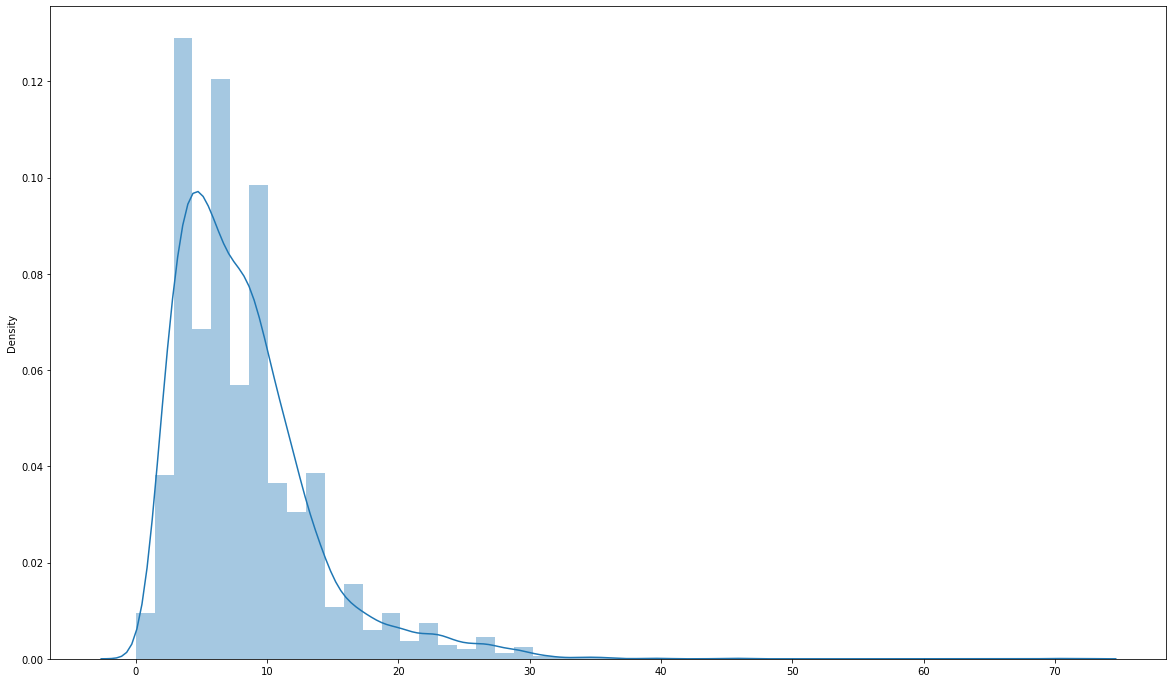

In [12]:


plt.figure(figsize=(20,12))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()



In [13]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [14]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

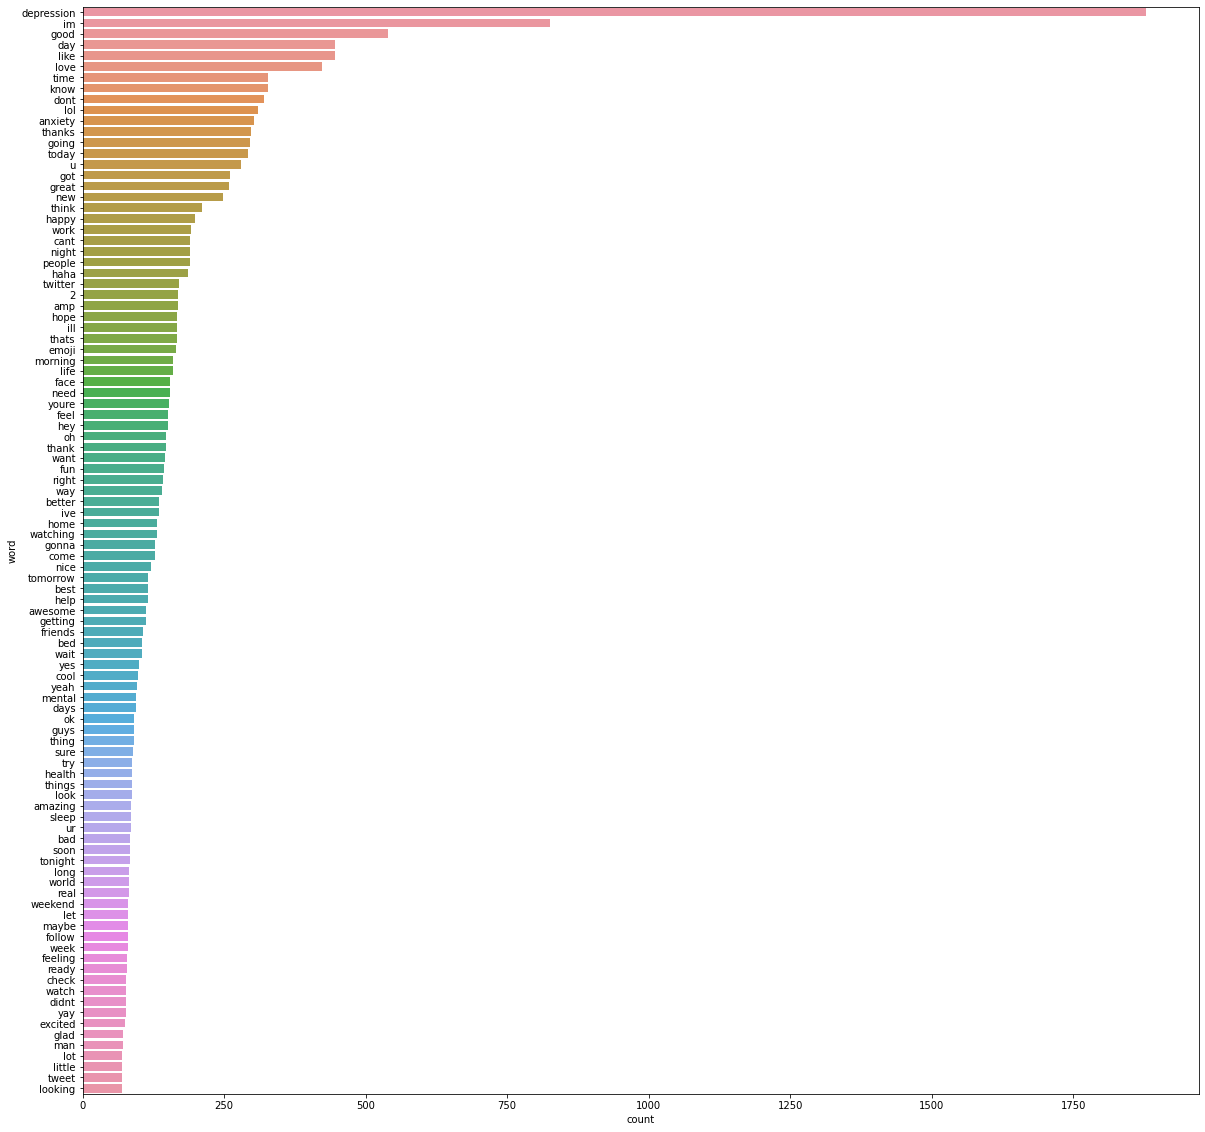

In [15]:
plt.figure(figsize=(20,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:100])
plt.show()

In [17]:


tweets = df.values[:,1]
labels = df.values[:,2].astype(float)
print (tweets[45], labels[45])
print (tweets[8005], labels[8005])



@modejunkie awww sweetness! But he's still a cutie!  0.0
my anxiety and my depression fighting over whos day it is  https://twitter.com/crissles/status/988218861697806336Â â¦ 1.0


In [18]:
#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [19]:

embeddings = bert_model.encode(tweets, show_progress_bar=True)

print (embeddings.shape)


#embeddings = bert_model.encode(df.message, show_progress_bar=True)
#print (embeddings.shape)


Batches: 100%|██████████| 323/323 [11:48<00:00,  2.19s/it]


(10314, 768)


In [20]:
embeddings

array([[-0.88297683,  0.045337  ,  1.038359  , ..., -0.28533867,
        -0.02419497, -0.21043606],
       [-0.43105194, -0.7311447 ,  0.6841728 , ...,  0.16172639,
         0.17172974, -0.6560318 ],
       [ 0.22631957, -0.38629708,  0.8538063 , ...,  0.02654455,
        -0.205984  ,  0.02080384],
       ...,
       [-0.2663838 , -0.32669133,  0.7152725 , ..., -0.10697744,
        -0.41044775,  0.29736015],
       [-0.87485933, -0.20091745,  0.28983176, ..., -0.26827544,
         0.05667134, -0.21770394],
       [-1.1190494 , -0.08939341,  0.03098689, ..., -0.17223687,
        -0.19136567,  0.36089864]], dtype=float32)

In [21]:
X = embeddings
y = df['label (depression result)']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#20% better

In [27]:
#Random Forest
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(random_state=1) #get instance of model
fit = model.fit(X_train, y_train) #train or fit model
y_pred=model.predict(X_test) #get y predictons
print(classification_report(y_test, y_pred)) #output accuracy

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1561
           1       0.98      0.83      0.90       502

    accuracy                           0.95      2063
   macro avg       0.97      0.91      0.93      2063
weighted avg       0.96      0.95      0.95      2063



In [98]:
#Hyperparameter tuning > HPs are parameters that can be adjusted and fine tuned in order to improve the performance of the machine learning model
#A hyperparameter is a parameter whose value is used to control the learning process. 
# Hyperparameters are points of choice or configuration that allow a machine learning model to be customised for a specific task or dataset.
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
A = rf_random.fit(X_train, y_train)
A



Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 64, 118, 173, 227,
                                                         282, 336, 391, 445,
                                                         500]},
                   random_state=42, verbose=2)

[[1554    7]
 [  87  415]]


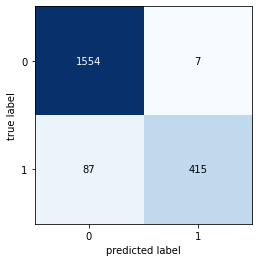

In [96]:
#infusion metrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm)
plt.show()
#How to interpret infusion metrix
#1554 is the amount of True Positives in our data, while 415 is the amount of True Negatives. 7 & 87 are the number of errors.
#There are 7 Type 1 errors (False Positives)- You predicted positive and it’s false.
#There are 87 Type 2 errors (False Negatives)- You predicted negative and it’s false. 
# Hence, if we calculate the accuracy its # Correct Predicted/ # Total.
#In other words, where TP, FN, FP and TN represent the number of true positives, false negatives, false positives and true negatives.

#Accuracy = (TP + TN)/(TP + TN + FP + FN).
#Accuracy =(1554+415)/(1554+415+7+87) = 1969/2063 = 0.9544 = 95.44% accuracy



In [97]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
not depressed


In [34]:
#Naives Bayes Classifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
model1= GaussianNB() #get instance of model
fit1 = model1.fit(X_train, y_train) #train or fit model
y_pred1=model1.predict(X_test) #get y predictons
print(classification_report(y_test, y_pred1)) #output accuracy

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1561
           1       0.83      0.91      0.87       502

    accuracy                           0.93      2063
   macro avg       0.90      0.92      0.91      2063
weighted avg       0.94      0.93      0.93      2063



[[1469   92]
 [  47  455]]


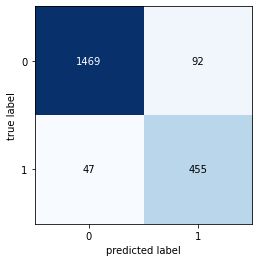

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm1 = confusion_matrix(y_test, y_pred1)
print(cm1)
accuracy_score(y_test, y_pred1)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm1)
plt.show()

In [50]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit1.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
not depressed


In [37]:
#SVM(Support Vectpr Machine)
from sklearn.metrics import classification_report
from sklearn.svm import SVC
model2 = SVC(random_state=1) #get instance of model
fit2 = model2.fit(X_train, y_train) #train or fit model
y_pred2 = model2.predict(X_test) #get y predictons
print(classification_report(y_test, y_pred2)) #output accuracy

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1561
           1       1.00      0.93      0.96       502

    accuracy                           0.98      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.98      0.98      0.98      2063



[[1559    2]
 [  34  468]]


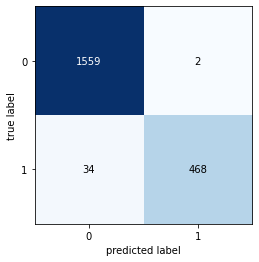

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)
accuracy_score(y_test, y_pred2)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm2)
plt.show()

In [51]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit2.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
depressed


In [39]:
#Logistic Regression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression(random_state=1) #get instance of model
fit3 = model3.fit(X_train, y_train) #train or fit model
y_pred3 = model3.predict(X_test) #get y predictons
print(classification_report(y_test, y_pred3)) #output accuracy

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1561
           1       0.99      0.95      0.97       502

    accuracy                           0.98      2063
   macro avg       0.98      0.97      0.98      2063
weighted avg       0.98      0.98      0.98      2063



[[1554    7]
 [  26  476]]


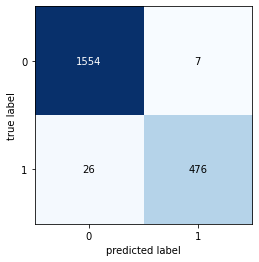

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm3 = confusion_matrix(y_test, y_pred3)
print(cm3)
accuracy_score(y_test, y_pred3)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm3)
plt.show()

In [52]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit3.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
depressed


In [41]:
#Decision Trees
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
model4 = DecisionTreeClassifier(random_state=1) #get instance of model
fit4 = model4.fit(X_train, y_train) #train or fit model
y_pred4 = model4.predict(X_test) #get y predictons
print(classification_report(y_test, y_pred4)) #output accuracy

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1561
           1       0.83      0.81      0.82       502

    accuracy                           0.91      2063
   macro avg       0.88      0.88      0.88      2063
weighted avg       0.91      0.91      0.91      2063



[[1484   77]
 [  40  462]]


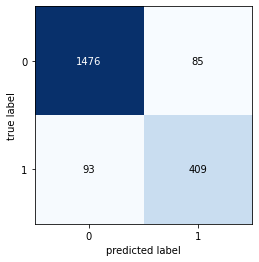

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm4 = confusion_matrix(y_test, y_pred4)
print(cm5)
accuracy_score(y_test, y_pred4)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm4)
plt.show()

In [53]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit4.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
depressed


In [54]:
#K-NN (K-Nearest Neighbors)
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
model5 = KNeighborsClassifier() #get instance of model
fit5 = model5.fit(X_train, y_train) #train or fit model
y_pred5 = model5.predict(X_test) #get y predictons
print(classification_report(y_test, y_pred5)) #output accuracy

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1561
           1       0.86      0.92      0.89       502

    accuracy                           0.94      2063
   macro avg       0.92      0.94      0.92      2063
weighted avg       0.95      0.94      0.94      2063



[[1484   77]
 [  40  462]]


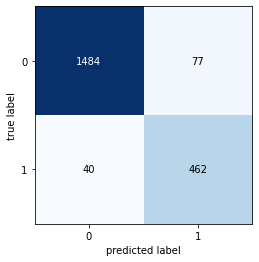

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm5 = confusion_matrix(y_test, y_pred5)
print(cm5)
accuracy_score(y_test, y_pred5)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm5)
plt.show()

In [79]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit5.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
depressed


In [ ]:
#Train the model

#X = embeddings
#y = df['label (depression result)'] or labels = df.values[:,2].astype(float)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, 
                                          test_size=0.2, random_state=42)
print ("Training set shapes:", X_train.shape, y_train.shape)
print ("Test set shapes:", X_test.shape, y_test.shape)

In [ ]:

#I used randomforestclassifier model, so don't know if this is necessary

#prediction using keras model
from tensorflow.keras import Sequential, layers
# Create the model
classifier = Sequential()
classifier.add (layers.Dense(128, activation='relu', input_shape=(768,))) #256
classifier.add (layers.Dense(1, activation='sigmoid'))#1
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
# Fit data to model
classifier.fit (X_train, y_train, epochs=10, batch_size=16, 
                      validation_data=(X_test, y_test))
#hist = classifier.fit (X_train, y_train, epochs=100, batch_size=16, 
                      #validation_data=(X_test, y_test))
##from sklearn.ensemble import RandomForestClassifier
#fit = RandomForestClassifier().fit(X_train, y_train)


In [ ]:
#Evaluating the model
score = classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#prediction

probability_model = tf.keras.Sequential([classifier,tf.keras.layers.Softmax()])
print(probability_model)
predictions = probability_model.predict(["the worst sadness is the sadness you've taught yourself to hide"])
print(predictions)

In [ ]:
#Predicting the output
y_pred = classifier.predict(X_test)
print(y_pred)
#save the model
classifier.save('twitter_depression.model')
#load the model
model = tf.keras.models.load_model("twitter_depression.model")
new_input = [["the worst sadness is the sadness you've taught yourself to hide"]]

In [81]:
words = np.array(['not depressed', 'depressed'])
Outcome = words[fit5.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])]
#[fit.predict([bert_model.encode('the worst sadness is the sadness you've taught yourself to hide.')])]
print(Outcome)

['depressed']


In [56]:
#RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
fit6 = RandomForestClassifier().fit(X_train, y_train)

In [57]:
print("The accuracy is : ")
np.sum(fit6.predict(X_test)==y_test)/len(y_test)

The accuracy is : 


0.956858943286476

In [58]:

#predict some tweets
[fit6.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])]
#[fit.predict([bert_model.encode('the worst sadness is the sadness you've taught yourself to hide.')])


[array([1])]

In [29]:
words = np.array(['not depressed', 'depressed'])

In [60]:
words = np.array(['not depressed', 'depressed'])
print("The outcome is: ")
print(words[fit6.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())

The outcome is: 
not depressed


In [88]:
from tkinter import *

root = Tk()
root.title('TechLabs medicine!')
root.geometry("400x400")


myTextbox1 = Entry(root, text="My text", width=30)
myTextbox1.pack()

def hello():
    hello_label = Label(root, text = "Your result is: " + myTextbox1.get())
    hello_label.pack()
def outcome():

myLabel = Label(root, text="Enter your tweets:")
myLabel.pack()


#myTextbox2 = Label(root, text=Outcome)

myButton = Button(root, text ="Submit", command=hello)
myButton.pack()

#creating a Label Widget
#myLabel1 = Label(root, text=words[fit.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])])
#myLabel2 = Label(root, text="I am Sumanta")
#Shoving in into the screen
#myLabel.pack()
#myLabel1.grid(row=0, column=1)
#myLabel2.grid(row=1, column=5)

#looping
root.mainloop()
#make buttons

IndentationError: expected an indented block (<ipython-input-88-b57b4a4da99d>, line 16)

In [58]:
print("The outcome is: ")
print(words[fit.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())
print(words[fit.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])].squeeze())
print(words[fit.predict([bert_model.encode("the best happiness is the sadness you've taught yourself to hide.")])].squeeze())

The outcome is: 
not depressed
depressed
depressed


In [ ]:
#new_output = model.predict(new_input)
#Xnew, _ = make_blobs(n_samples=3, centers=2, n_features=2, random_state=1)
#Xnew = scalar.transform(Xnew)
# make a prediction
#ynew = model.predict_classes(Xnew)
# show the inputs and predicted outputs


#for i in range(len(X_train)):
	#print("X_train=%s, Predicted=%s" % (X_train[i], y_train[i]))

#embeddings = bert_model.encode(df.message, show_progress_bar=True)
#print (embeddings.shape)
#Not necessary
feature_names=word_freq['word'].values
wc=WordCloud(max_words=200)
wc.generate(' '.join(word for word in feature_names[500:2500] ))
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(wc)
#wc.generate(' '.join(word for word in feature_names[500:3500] ))